In [1]:
import pickle
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("../input/smart-reply-sentence-similarity/input_texts.pickle", 'rb') as handle:
    input_texts = pickle.load(handle)

In [3]:
tqdm.pandas()
df = pd.read_csv("../input/smart-reply-sentence-similarity/input_similarity_matrix.txt", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15831,15832,15833,15834,15835,15836,15837,15838,15839,15840
0,[0.0,0.028734,0.027896,0.034412,0.031692,0.030466,0.063301,0.039833,0.039226,0.034412,...,0.045533,0.029787,0.029133,0.021897,0.020846,0.031487,0.063886,0.027929,0.037734,0.0320625901222229]
1,[0.028733551502227783,0.000000,0.024473,0.012667,0.020592,0.010325,0.045364,0.013770,0.016877,0.012667,...,0.030869,0.008784,0.016132,0.016506,0.011956,0.018705,0.035486,0.014873,0.017064,0.015716552734375]
2,[0.027895689010620117,0.024473,0.000000,0.033816,0.014762,0.027025,0.052140,0.038405,0.035809,0.033816,...,0.041643,0.028751,0.021723,0.026664,0.022712,0.030015,0.058062,0.026405,0.032695,0.031088829040527344]
3,[0.0344119668006897,0.012667,0.033816,0.000000,0.025240,0.004443,0.059595,0.007277,0.008881,0.000000,...,0.033340,0.009798,0.016464,0.010436,0.015498,0.023792,0.028518,0.014157,0.008842,0.02057814598083496]
4,[0.03169173002243042,0.020592,0.014762,0.025240,0.000000,0.024405,0.047637,0.024676,0.033265,0.025240,...,0.028596,0.023108,0.016733,0.022498,0.019728,0.015570,0.042603,0.021523,0.031186,0.029881536960601807]


In [4]:
# first and last column data contains [ and ]
df.iloc[:,0]

0                         [0.0
1        [0.028733551502227783
2        [0.027895689010620117
3          [0.0344119668006897
4         [0.03169173002243042
                 ...          
15836    [0.031486690044403076
15837     [0.06388592720031738
15838     [0.02792912721633911
15839     [0.03773373365402222
15840      [0.0320625901222229
Name: 0, Length: 15841, dtype: object

In [5]:
df.iloc[:,-1:]

,15840
0,0.0320625901222229]
1,0.015716552734375]
2,0.031088829040527344]
3,0.02057814598083496]
4,0.029881536960601807]
...,...
15836,0.023702800273895264]
15837,0.03144943714141846]
15838,0.01103067398071289]
15839,0.019704699516296387]


In [6]:
# cleaning first and last columns
df.iloc[:,0] = df.iloc[:,0].str.replace("[", "").str.strip()
df.iloc[:,-1:] = df.iloc[:,-1].str.replace("]", "").str.strip()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
df.iloc[:,0]

0                         0.0
1        0.028733551502227783
2        0.027895689010620117
3          0.0344119668006897
4         0.03169173002243042
                 ...         
15836    0.031486690044403076
15837     0.06388592720031738
15838     0.02792912721633911
15839     0.03773373365402222
15840      0.0320625901222229
Name: 0, Length: 15841, dtype: object

In [8]:
df.iloc[:,-1:]

,15840
0,0.0320625901222229
1,0.015716552734375
2,0.031088829040527344
3,0.02057814598083496
4,0.029881536960601807
...,...
15836,0.023702800273895264
15837,0.03144943714141846
15838,0.01103067398071289
15839,0.019704699516296387


In [9]:
# converting datatype to float
input_similarity_matrix = df.astype(float)
input_similarity_matrix.describe()

,0,1,2,3,4,5,6,7,8,9,...,15831,15832,15833,15834,15835,15836,15837,15838,15839,15840
count,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,...,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000,15841.000000
mean,0.040852,0.026237,0.037013,0.026025,0.032498,0.025518,0.056041,0.030081,0.028649,0.026025,...,0.042082,0.026227,0.027419,0.028036,0.027468,0.031947,0.043230,0.028446,0.027229,0.032016
std,0.014149,0.013194,0.013171,0.016351,0.012618,0.015533,0.013745,0.016990,0.017181,0.016351,...,0.019706,0.013946,0.013065,0.015708,0.013325,0.015246,0.021469,0.014444,0.016797,0.014543
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030924,0.016900,0.028585,0.013699,0.023896,0.013959,0.046983,0.018894,0.016833,0.013699,...,0.029303,0.016499,0.018263,0.017348,0.017872,0.021443,0.028711,0.018663,0.015644,0.022215
50%,0.037460,0.022473,0.033457,0.022994,0.029428,0.021984,0.054865,0.025745,0.026057,0.022994,...,0.038234,0.022993,0.023784,0.024109,0.023863,0.029488,0.038353,0.025604,0.025095,0.028623
75%,0.047054,0.031735,0.042838,0.034193,0.037515,0.033850,0.062590,0.036764,0.037638,0.034193,...,0.049842,0.033172,0.034010,0.036261,0.033035,0.038471,0.053399,0.033938,0.035973,0.038174
max,0.125754,0.115644,0.116545,0.119274,0.114803,0.114957,0.147932,0.142525,0.129412,0.119274,...,0.173402,0.113865,0.119366,0.120635,0.108018,0.138511,0.168584,0.125378,0.123035,0.130154


In [10]:
# finding 10th neighbour distance to sentence 1
input_similarity_matrix.iloc[1].nsmallest(10).iloc[10-1]

0.0068166255950927

In [11]:
# extending logic to all rows
def sort_and_select_10_neigh_dist(row):
    return row.nsmallest(10).iloc[10-1]

neighbor_10_dist = input_similarity_matrix.apply(sort_and_select_10_neigh_dist, axis = 1) 

In [12]:
neighbor_10_dist.describe()

count    15841.000000
mean         0.007815
std          0.007173
min          0.000000
25%          0.001760
50%          0.006844
75%          0.011797
max          0.067153
dtype: float64

In [13]:
for x in list(input_similarity_matrix.nsmallest(10, 1).index.astype(int)):
    print(input_texts[x], " - Similarity Score :", input_similarity_matrix[x][1]) 

by the way do you like fish ?  - Similarity Score : 0.0
by the way do you like dogs ?  - Similarity Score : 0.0023227334022521
by the way do you like cars ?  - Similarity Score : 0.0033760070800781
by the way do you like football ?  - Similarity Score : 0.0042977929115295
on a different note do you like dogs ?  - Similarity Score : 0.0056469440460205
do you like looking up at the stars ?  - Similarity Score : 0.0056816935539245
do you like dogs or cats more ?  - Similarity Score : 0.0061844587326049
how do you like the blue color ?  - Similarity Score : 0.0064437389373779
do you like any animals by the way ?  - Similarity Score : 0.0067468881607055
do you like the temptations ?  - Similarity Score : 0.0068166255950927


In [14]:
# using 40th percentile value as appropriate distance for 10th neighbour
eps_10 = neighbor_10_dist.quantile(0.99)
print(eps_10)

0.030684375762939406


In [15]:
eps_range = [neighbor_10_dist.quantile(0.1), neighbor_10_dist.quantile(0.25), neighbor_10_dist.quantile(0.95),
            neighbor_10_dist.quantile(0.99), 0.7, 0.8, 0.9, 1.0, 1.5, 2, 3, 4, 5, 8, 10]


eps_num_clusters = list()
eps_num_noise = list()

for eps_num in eps_range:
    
    print("Taking EPS as", eps_num)
    # Compute DBSCAN
    db = DBSCAN(eps=eps_10, min_samples=10, n_jobs=-1).fit(input_similarity_matrix)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    eps_num_clusters.append(n_clusters_)
    eps_num_noise.append(n_noise_)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("-----------")

Taking EPS as 0.0
Estimated number of clusters: 100
Estimated number of noise points: 12197
-----------
Taking EPS as 0.0017603039741516
Estimated number of clusters: 100
Estimated number of noise points: 12197
-----------
Taking EPS as 0.0206244587898254
Estimated number of clusters: 100
Estimated number of noise points: 12197
-----------
Taking EPS as 0.030684375762939406
Estimated number of clusters: 100
Estimated number of noise points: 12197
-----------
Taking EPS as 0.7
Estimated number of clusters: 100
Estimated number of noise points: 12197
-----------
Taking EPS as 0.8
Estimated number of clusters: 100
Estimated number of noise points: 12197
-----------
Taking EPS as 0.9
Estimated number of clusters: 100
Estimated number of noise points: 12197
-----------
Taking EPS as 1.0
Estimated number of clusters: 100
Estimated number of noise points: 12197
-----------
Taking EPS as 1.5
Estimated number of clusters: 100
Estimated number of noise points: 12197
-----------
Taking EPS as 2
E

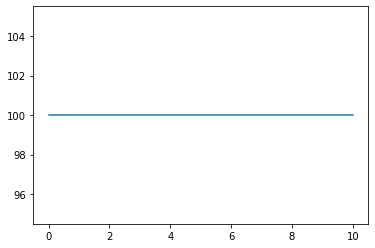

In [16]:
plt.plot(eps_range, eps_num_clusters)
plt.show()

In [17]:
# Plot result

# Black removed and is used for noise instead.
"""
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()
"""

"\nunique_labels = set(labels)\ncolors = [plt.cm.Spectral(each)\n          for each in np.linspace(0, 1, len(unique_labels))]\nfor k, col in zip(unique_labels, colors):\n    if k == -1:\n        # Black used for noise.\n        col = [0, 0, 0, 1]\n        continue\n\n    class_member_mask = (labels == k)\n\n    xy = X[class_member_mask & core_samples_mask]\n    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),\n             markeredgecolor='k', markersize=14)\n\n    xy = X[class_member_mask & ~core_samples_mask]\n    plt.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),\n             markeredgecolor='k', markersize=6)\n\nplt.title('Estimated number of clusters: %d' % n_clusters_)\nplt.show()\n"

In [18]:
"""
from collections import Counter

for unique_label in set(labels):
    
    class_member_mask = (labels == unique_label)
    print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")
    print("Samples")
    print(np.array(input_texts)[class_member_mask])
    print("-------------------------------------")
    #print(Counter(class_member_mask).keys()) # equals to list(set(words))
    #Counter(words).values() # counts the elements' frequency
"""

'\nfrom collections import Counter\n\nfor unique_label in set(labels):\n    \n    class_member_mask = (labels == unique_label)\n    print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")\n    print("Samples")\n    print(np.array(input_texts)[class_member_mask])\n    print("-------------------------------------")\n    #print(Counter(class_member_mask).keys()) # equals to list(set(words))\n    #Counter(words).values() # counts the elements\' frequency\n'